In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
from pprint import pprint

import re

from tqdm import tqdm_notebook

import scipy
from scipy import sparse
from scipy import stats

import pubchempy as pcp
from chembl_webresource_client.new_client import new_client 
import json
import requests

import copy

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

In [2]:
import sys
sys.path.append("..")
import utils
import numpy as np

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [3]:
#all labels:
interaction_matrix = sparse.load_npz('../data/interaction_matrix_pchembl.npz')
smiles = pd.read_csv('../data/pchembl_chemicals.csv')
targets = pd.read_csv('../data/subset_targets.csv')

In [4]:
probability_matrix = utils.train_label_correlation(interaction_matrix)

  0%|          | 265/85681 [00:00<00:33, 2583.81it/s]

y_in shape is: (337951, 243)


100%|██████████| 337951/337951 [00:57<00:00, 5858.11it/s]


In [8]:
train, test, fps = utils.load_time_split(year=2030, return_fingerprints=True) #set a year after now

In [9]:
##The following is to calculate AVE bias:
def fast_jaccard(X, Y=None):
    """credit: https://stackoverflow.com/questions/32805916/compute-jaccard-distances-on-sparse-matrix"""
    if isinstance(X, np.ndarray):
        X = sparse.csr_matrix(X)
    if Y is None:
        Y = X
    else:
        if isinstance(Y, np.ndarray):
            Y = sparse.csr_matrix(Y)
    assert X.shape[1] == Y.shape[1]

    X = X.astype(bool).astype(int)
    Y = Y.astype(bool).astype(int)
    intersect = X.dot(Y.T)
    x_sum = X.sum(axis=1).A1
    y_sum = Y.sum(axis=1).A1
    xx, yy = np.meshgrid(x_sum, y_sum)
    union = ((xx + yy).T - intersect)
    return (1 - intersect / union).A


In [6]:
probability_arr = probability_matrix.toarray()

In [7]:
arr = probability_matrix.toarray()
arr = arr - interaction_matrix
arr_sorted = np.dstack(np.unravel_index(np.argsort(-arr.ravel()), (arr.shape[0], arr.shape[1])))[0]
print('Should be a high number < 1:')
print(probability_arr[arr_sorted[0][0]][arr_sorted[0][1]])
print('Should be a low number >= 0:')
print(probability_arr[arr_sorted[-1][0]][arr_sorted[-1][1]])
print('Sorted array indices:')
arr_sorted

Should be a high number < 1:
0.99991256
Should be a low number >= 0:
0.0
Sorted array indices:


array([[328242,    138],
       [ 68104,    138],
       [315225,     72],
       ...,
       [132327,     26],
       [132327,     28],
       [337950,    242]])

In [28]:

n = 500000
probs = probability_arr[arr_sorted[:n][:,0], arr_sorted[:n][:,1]]

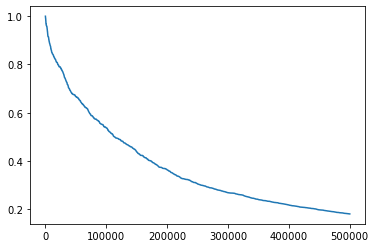

In [29]:
import matplotlib.pyplot as plt
plt.plot(probs)

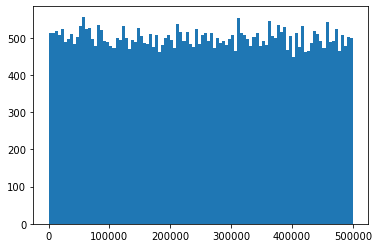

In [33]:
_ =plt.hist(np.random.choice(n, 50000, replace=False), bins=100)

In [12]:
##Test that it lines up:
for pair in arr_sorted[:10]:
    smi = smiles['canonical_smiles'].iloc[pair[0]]
    chembl_id = smiles['instance_id'].iloc[pair[0]]
    predicted_target = targets['pref_name'].iloc[pair[1]]
    tid = targets[targets['pref_name']==predicted_target]['pref_name'].iloc[0]
    print(smi[:10]+'...', predicted_target, '\t', tid)
    print(chembl_id, smi)


C[C@@H](Oc... Vascular endothelial growth factor receptor 2 	 Vascular endothelial growth factor receptor 2
CHEMBL601719 C[C@@H](Oc1cc(cnc1N)c2cnn(c2)C3CCNCC3)c4c(Cl)ccc(F)c4Cl
Nc1ncnc2sc... Vascular endothelial growth factor receptor 2 	 Vascular endothelial growth factor receptor 2
CHEMBL1998585 Nc1ncnc2scc(c3ccc(NC(=O)Nc4cc(ccc4F)C(F)(F)F)cc3)c12
CCN(CC)CCN... Serine/threonine-protein kinase PIM1 	 Serine/threonine-protein kinase PIM1
CHEMBL535 CCN(CC)CCNC(=O)c1c(C)[nH]c(\C=C\2/C(=O)Nc3ccc(F)cc23)c1C
CNC(=O)c1c... Vascular endothelial growth factor receptor 2 	 Vascular endothelial growth factor receptor 2
CHEMBL2005631 CNC(=O)c1cnc(N)c2c(csc12)c3ccc(NC(=O)Nc4cc(C)ccc4F)cc3
Cn1cc(cn1)... Vascular endothelial growth factor receptor 2 	 Vascular endothelial growth factor receptor 2
CHEMBL1988717 Cn1cc(cn1)c2cnn3c(N)c(cnc23)c4ccc(NC(=O)Nc5cccc(c5)C(F)(F)F)cc4
Cc1ccc(NC(... Vascular endothelial growth factor receptor 2 	 Vascular endothelial growth factor receptor 2
CHEMBL2000335 Cc1ccc

In [13]:
def get_nnrank_of_target(ligand_idx, target_idx):
    positives = interaction_matrix[ligand_idx].nonzero()[1]
    all_distances = all_distances =fast_jaccard(fps[ligand_idx], fps)[0]
    s = np.argsort(all_distances)
    
    pred = target_idx
    curr_rank = 0
    count=1
    preds = []
    seen = []

    while pred not in preds:
        predictions = interaction_matrix[s[count]].nonzero()[1]
    
        preds = np.setdiff1d(predictions,positives)
        preds = np.setdiff1d(preds, seen)
        seen += list(preds)
        curr_rank += 0 if len(preds)<1 else np.mean(np.arange(len(preds))+1)

        count+=1
    return curr_rank
    #rank = (np.array(seen)[np.sort(np.unique(seen, return_index=True)[1])] == pred).nonzero()[0] + 1
    return rank

In [14]:
def clean_text(input_string):
    #source: https://stackoverflow.com/questions/34860982/replace-the-punctuation-with-whitespace
    #replace these with whitespace:
    clean_string = re.sub(r"""
               [(),.;@#?!&$]+  # Accept one or more copies of punctuation
               \ *           # plus zero or more copies of a space,
               """,
               " ",          # and replace it with a single space
               input_string.lower(), flags=re.VERBOSE)
    
    #replace these with nothing:
    clean_string = clean_string.replace('-', '')
    clean_string = clean_string.replace('=', '')
    return clean_string


def get_synonyms(tid):
    target = new_client.target
    res = target.filter(target_chembl_id=tid)
    target_synonyms = [i['component_synonym'] for i in res[0]['target_components'][0]['target_component_synonyms']]
    #clean:
    target_synonyms = [clean_text(i) for i in target_synonyms]
    #make all lowercase to improve correct matchings:
    #target_synonyms = [i.lower() for i in target_synonyms]
    #remove all punctuations to improve correct matchings:
    #target_synonyms = [i.translate(str.maketrans('', '', string.punctuation)) for i in target_synonyms]
    
    return target_synonyms

def get_cid(smi):
    try:
        c = pcp.get_compounds(smi, 'smiles')[0]
        return c.cid
    except Exception as e:
        print(e)
        return None

def get_assay_summary(cid):
    b = json.loads(requests.get('https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/'+str(cid)+'/assaysummary/JSON').content)
    return b

def get_relevant_aids(assay_summary, synonyms):
    #iterates through all assays and checks for overlap in Assay Name with any of the synonyms. 
    #if there is a shared word, returns the pubchem assay ID. 
    #relevant_aids = list()
    bioactivity_outcomes = list()
    assay_names = list()
    
    for i in assay_summary['Table']['Row']:
        assay_name = i['Cell'][11]
        #trick from word embedding - remove all punctuations to improve word matching
        #assay_name = assay_name.translate(str.maketrans('', '', string.punctuation))
        clean_assay_name = clean_text(assay_name)
        #now match words:
        if len(set(synonyms).intersection(clean_assay_name.split()))>0:
            
            ###This is the variable that stores the 'active' or 'unspecified' or 'inactive' string:
            bioactivity_outcome = i['Cell'][6]
            ###
            
            bioactivity_outcomes.append(bioactivity_outcome)
            assay_names.append(assay_name)
            
            #this stores the AID number
            #relevant_aids.append(i['Cell'][0])

    return bioactivity_outcomes, assay_names#relevant_aids

def get_assay_details(aid, cid):
    b = json.loads(requests.get('https://pubchem.ncbi.nlm.nih.gov/rest/pug/assay/aid/'+str(aid)+'/JSON?cid='+str(cid)).content)
    return b

def get_pair_details(pair):
    smi = smiles['canonical_smiles'].iloc[pair[0]]
    instance_id = smiles['instance_id'].iloc[pair[0]]
    predicted_target = targets['pref_name'].iloc[pair[1]]
    tid = targets[targets['pref_name']==predicted_target]['chembl_id'].iloc[0]
    return smi, instance_id, tid, predicted_target


In [15]:
def fetch_assay_details(tid, smi):
    if tid in synonym_dict:
        synonyms = synonym_dict[tid]
    else:
        synonyms = get_synonyms(tid)
        synonym_dict[tid] = synonyms

        
    if smi in cid_dict:
        compound_id = cid_dict[smi]
    else:
        compound_id = get_cid(smi)
        cid_dict[smi] = compound_id
        
    if compound_id in assay_dict:
        assay_summary = assay_dict[compound_id]
    else: 
        assay_summary = get_assay_summary(compound_id)
        assay_dict[compound_id]=assay_summary
        
    return synonyms, compound_id, assay_summary

In [16]:

# import time as time
# import signal
# #Close session
# def handler(signum, frame):
#     raise Exception('Action took too much time')
# signal.signal(signal.SIGALRM, handler)
# signal.alarm(35) #Set the parameter to the amount of seconds you want to wait



synonym_dict = dict()
cid_dict = dict()
assay_dict = dict()
assays_long = pd.DataFrame(columns=['ligandIdx', 'targetIdx', 'instance_id', 'pref_name', 'outcome', 'assayname'])
rownum=0

    
resultdict = dict()


for count, pair in tqdm_notebook(enumerate(arr_sorted[:10000]), smoothing=0, total=10000):
    print(f'testing {count}th pair: {pair} ... ', end=' ')
    
    #first, check if it would have been predicted using nearest neighbors anyway:
    rank = get_nnrank_of_target(pair[0], pair[1])
    if rank>3:
        pass
    else:
        print(f'skipping, rank was {rank}')
        resultdict[count] = 'lowrank'
        continue
        
    #next, ping pubchem for assays. 
    try:
        smi, instance_id, tid, pref_name = get_pair_details(pair)
    
        synonyms, compound_id, assay_summary = fetch_assay_details(tid, smi )
    
    
        if 'Fault' in assay_summary.keys():
            None
            #print('No assays present.')
        else:
            bioactivity_outcomes, assay_names = get_relevant_aids(assay_summary, synonyms)
            for outcome, aname in zip(bioactivity_outcomes, assay_names):
                assays_long.loc[rownum]=[pair[0], pair[1], instance_id, pref_name, outcome, aname]
                resultdict[count] = 'success'
                rownum += 1
    
        if count%100==0:
            assays_long.to_csv('assays_long.csv')
        print(' - finished.')
    except (KeyboardInterrupt, Exception):
        resultdict[count] = 'exception'
        print('took too long. moving on.')



/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


testing 0th pair: [328242    138] ...  skipping, rank was 3.0
testing 1th pair: [68104   138] ...  skipping, rank was 1.5
testing 2th pair: [315225     72] ...   - finished.
testing 3th pair: [68544   138] ...  skipping, rank was 1.5
testing 4th pair: [67490   138] ...   - finished.
testing 5th pair: [68211   138] ...   - finished.
testing 6th pair: [68422    72] ...   - finished.
testing 7th pair: [68566    72] ...  skipping, rank was 2.0
testing 8th pair: [325691     72] ...   - finished.
testing 9th pair: [12252    72] ...   - finished.
testing 10th pair: [66867   138] ...   - finished.
testing 11th pair: [66521   138] ...   - finished.
testing 12th pair: [106854    178] ...   - finished.
testing 13th pair: [275867    138] ...  skipping, rank was 3.0
testing 14th pair: [135871    138] ...  skipping, rank was 2.5
testing 15th pair: [65968   138] ...   - finished.
testing 16th pair: [68378   138] ...   - finished.
testing 17th pair: [123454    138] ...  skipping, rank was 2.5
testing 

testing 274th pair: [140615    127] ...  skipping, rank was 1.0
testing 275th pair: [83541   127] ...  skipping, rank was 1.0
testing 276th pair: [121095    127] ...  skipping, rank was 2.0
testing 277th pair: [36100   127] ...   - finished.
testing 278th pair: [216390    127] ...   - finished.
testing 279th pair: [16158   127] ...  skipping, rank was 1.0
testing 280th pair: [10590   127] ...  skipping, rank was 1.0
testing 281th pair: [128861    127] ...   - finished.
testing 282th pair: [138390    127] ...  skipping, rank was 1.0
testing 283th pair: [217908    127] ...  skipping, rank was 1.0
testing 284th pair: [132713    127] ...  skipping, rank was 2.0
testing 285th pair: [138386    127] ...  skipping, rank was 1.0
testing 286th pair: [138306    127] ...  skipping, rank was 2.0
testing 287th pair: [132696    127] ...  skipping, rank was 1.0
testing 288th pair: [29285   127] ...  skipping, rank was 3.0
testing 289th pair: [138387    127] ...  skipping, rank was 1.0
testing 290th pa

testing 407th pair: [215581     52] ...  skipping, rank was 1.0
testing 408th pair: [298913     52] ...  skipping, rank was 2.0
testing 409th pair: [110854     52] ...  skipping, rank was 1.5
testing 410th pair: [93739    52] ...  skipping, rank was 2.5
testing 411th pair: [215261     52] ...  skipping, rank was 1.0
testing 412th pair: [216259     52] ...  skipping, rank was 2.5
testing 413th pair: [215195     52] ...  skipping, rank was 1.0
testing 414th pair: [215362     52] ...  skipping, rank was 1.0
testing 415th pair: [94019    52] ...  skipping, rank was 1.0
testing 416th pair: [215094     52] ...  skipping, rank was 3.0
testing 417th pair: [215231     52] ...   - finished.
testing 418th pair: [68213   149] ...   - finished.
testing 419th pair: [66933    79] ...   - finished.
testing 420th pair: [282277     76] ...  skipping, rank was 1.0
testing 421th pair: [26662   138] ...   - finished.
testing 422th pair: [66192    72] ...  skipping, rank was 1.5
testing 423th pair: [81968  

testing 678th pair: [98622   177] ...  skipping, rank was 1.0
testing 679th pair: [165687    177] ...  skipping, rank was 1.0
testing 680th pair: [98623   177] ...  skipping, rank was 1.0
testing 681th pair: [225382    177] ...  skipping, rank was 1.0
testing 682th pair: [98624   177] ...  skipping, rank was 1.0
testing 683th pair: [98626   177] ...  skipping, rank was 1.0
testing 684th pair: [48086   177] ...  skipping, rank was 1.0
testing 685th pair: [37771    90] ...   - finished.
testing 686th pair: [68287    79] ...  skipping, rank was 1.0
testing 687th pair: [36256    76] ...  skipping, rank was 2.0
testing 688th pair: [36264    76] ...  skipping, rank was 1.5
testing 689th pair: [240170     91] ...  skipping, rank was 1.0
testing 690th pair: [94698    91] ...  skipping, rank was 1.0
testing 691th pair: [148057     91] ...  skipping, rank was 1.0
testing 692th pair: [264751     91] ...  skipping, rank was 1.0
testing 693th pair: [148045     91] ...  skipping, rank was 1.0
testin

testing 817th pair: [310556     62] ...  skipping, rank was 1.0
testing 818th pair: [299344     62] ...  skipping, rank was 1.0
testing 819th pair: [298709     62] ...  skipping, rank was 1.0
testing 820th pair: [297869     62] ...  skipping, rank was 1.0
testing 821th pair: [15443    90] ...   - finished.
testing 822th pair: [89191    90] ...   - finished.
testing 823th pair: [67382   142] ...   - finished.
testing 824th pair: [121572     14] ...   - finished.
testing 825th pair: [67382    48] ...  skipping, rank was 1.5
testing 826th pair: [36363    90] ...   - finished.
testing 827th pair: [130082     76] ...   - finished.
testing 828th pair: [273226     76] ...  skipping, rank was 1.5
testing 829th pair: [67496   142] ...   - finished.
testing 830th pair: [305639     72] ...   - finished.
testing 831th pair: [4534  142] ...   - finished.
testing 832th pair: [66933   142] ...   - finished.
testing 833th pair: [67372   142] ...   - finished.
testing 834th pair: [20634   142] ...   - 

testing 1092th pair: [164343     52] ...  skipping, rank was 1.5
testing 1093th pair: [271588     52] ...   - finished.
testing 1094th pair: [97836    52] ...  skipping, rank was 1.5
testing 1095th pair: [97834    52] ...  skipping, rank was 1.5
testing 1096th pair: [164344     52] ...  skipping, rank was 1.5
testing 1097th pair: [64942    52] ...   - finished.
testing 1098th pair: [97833    52] ...  skipping, rank was 1.0
testing 1099th pair: [97832    52] ...  skipping, rank was 1.0
testing 1100th pair: [305108     52] ...   - finished.
testing 1101th pair: [142974     52] ...  skipping, rank was 2.0
testing 1102th pair: [216575     52] ...  skipping, rank was 1.0
testing 1103th pair: [155363     52] ...   - finished.
testing 1104th pair: [153290     52] ...   - finished.
testing 1105th pair: [109879     52] ...  skipping, rank was 1.5
testing 1106th pair: [109870     52] ...   - finished.
testing 1107th pair: [98988    52] ...   - finished.
testing 1108th pair: [96023    52] ...  sk

testing 1359th pair: [321687     90] ...  skipping, rank was 1.0
testing 1360th pair: [4050   90] ...  skipping, rank was 1.0
testing 1361th pair: [3581   90] ...  skipping, rank was 1.0
testing 1362th pair: [37896    90] ...  skipping, rank was 1.0
testing 1363th pair: [4655   90] ...  skipping, rank was 2.0
testing 1364th pair: [4654   90] ...  skipping, rank was 2.0
testing 1365th pair: [146952     90] ...  skipping, rank was 1.0
testing 1366th pair: [230938     90] ...  skipping, rank was 1.0
testing 1367th pair: [275600     90] ...  skipping, rank was 1.0
testing 1368th pair: [77891    90] ...  skipping, rank was 1.0
testing 1369th pair: [11688    90] ...  skipping, rank was 1.5
testing 1370th pair: [4767   90] ...  skipping, rank was 1.0
testing 1371th pair: [281668     90] ...  skipping, rank was 2.0
testing 1372th pair: [30599    90] ...  skipping, rank was 1.0
testing 1373th pair: [4037   90] ...  skipping, rank was 1.0
testing 1374th pair: [98116    90] ...  skipping, rank wa

testing 1626th pair: [194550    138] ...  skipping, rank was 2.0
testing 1627th pair: [194546    138] ...  skipping, rank was 2.0
testing 1628th pair: [194569    138] ...  skipping, rank was 1.5
testing 1629th pair: [191370    138] ...  skipping, rank was 2.0
testing 1630th pair: [258518    138] ...  skipping, rank was 1.5
testing 1631th pair: [194517    138] ...  skipping, rank was 1.5
testing 1632th pair: [191377    138] ...  skipping, rank was 1.5
testing 1633th pair: [191376    138] ...  skipping, rank was 1.5
testing 1634th pair: [194553    138] ...  skipping, rank was 2.0
testing 1635th pair: [191371    138] ...  skipping, rank was 2.0
testing 1636th pair: [247564    138] ...  skipping, rank was 1.5
testing 1637th pair: [194531    138] ...  skipping, rank was 1.5
testing 1638th pair: [262637    138] ...  skipping, rank was 2.0
testing 1639th pair: [191375    138] ...  skipping, rank was 2.5
testing 1640th pair: [194549    138] ...  skipping, rank was 1.5
testing 1641th pair: [191

testing 1887th pair: [217252    127] ...  skipping, rank was 1.0
testing 1888th pair: [50450   127] ...  skipping, rank was 2.0
testing 1889th pair: [267705    127] ...   - finished.
testing 1890th pair: [13746   127] ...   - finished.
testing 1891th pair: [65217   127] ...  skipping, rank was 1.0
testing 1892th pair: [333796    127] ...  skipping, rank was 2.5
testing 1893th pair: [275031    127] ...  skipping, rank was 1.5
testing 1894th pair: [62310   127] ...  skipping, rank was 1.0
testing 1895th pair: [128470    127] ...  skipping, rank was 2.0
testing 1896th pair: [247934    127] ...  skipping, rank was 1.5
testing 1897th pair: [217412    127] ...  skipping, rank was 1.0
testing 1898th pair: [271588    127] ...   - finished.
testing 1899th pair: [64942   127] ...   - finished.
testing 1900th pair: [322286    127] ...  skipping, rank was 1.0
testing 1901th pair: [278691    127] ...   - finished.
testing 1902th pair: [22714   127] ...   - finished.
testing 1903th pair: [322257    

testing 2149th pair: [185609    149] ...   - finished.
testing 2150th pair: [185610    149] ...  skipping, rank was 1.5
testing 2151th pair: [185611    149] ...  skipping, rank was 2.0
testing 2152th pair: [232066    149] ...  skipping, rank was 1.0
testing 2153th pair: [185612    149] ...  skipping, rank was 3.0
testing 2154th pair: [185613    149] ...  skipping, rank was 1.5
testing 2155th pair: [185614    149] ...  skipping, rank was 2.0
testing 2156th pair: [185615    149] ...  skipping, rank was 1.5
testing 2157th pair: [269706    149] ...  skipping, rank was 2.0
testing 2158th pair: [188789    149] ...  skipping, rank was 1.5
testing 2159th pair: [185626    149] ...  skipping, rank was 2.0
testing 2160th pair: [185627    149] ...  skipping, rank was 1.5
testing 2161th pair: [188466    149] ...  skipping, rank was 1.5
testing 2162th pair: [188465    149] ...  skipping, rank was 1.5
testing 2163th pair: [188801    149] ...  skipping, rank was 1.5
testing 2164th pair: [188797    149

testing 2408th pair: [162761     63] ...  skipping, rank was 1.0
testing 2409th pair: [63329    63] ...  skipping, rank was 1.0
testing 2410th pair: [67641    63] ...  skipping, rank was 1.0
testing 2411th pair: [67661    63] ...  skipping, rank was 1.0
testing 2412th pair: [67662    63] ...  skipping, rank was 1.0
testing 2413th pair: [66232    63] ...  skipping, rank was 1.0
testing 2414th pair: [36726    63] ...   - finished.
testing 2415th pair: [36725    63] ...   - finished.
testing 2416th pair: [36724    63] ...   - finished.
testing 2417th pair: [77894    63] ...  skipping, rank was 1.0
testing 2418th pair: [15615    63] ...  skipping, rank was 1.0
testing 2419th pair: [332224     63] ...  skipping, rank was 1.0
testing 2420th pair: [292812     63] ...  skipping, rank was 1.0
testing 2421th pair: [93056    63] ...  skipping, rank was 1.0
testing 2422th pair: [209784     63] ...  skipping, rank was 1.0
testing 2423th pair: [159202     63] ...  skipping, rank was 1.0
testing 2424

testing 2540th pair: [331019    177] ...   - finished.
testing 2541th pair: [326011    177] ...  skipping, rank was 1.0
testing 2542th pair: [221018    177] ...   - finished.
testing 2543th pair: [132701    177] ...  skipping, rank was 1.5
testing 2544th pair: [326256    177] ...  skipping, rank was 1.0
testing 2545th pair: [114080    177] ...   - finished.
testing 2546th pair: [43388   177] ...  skipping, rank was 1.5
testing 2547th pair: [278769    177] ...  skipping, rank was 1.0
testing 2548th pair: [326135    177] ...  skipping, rank was 1.0
testing 2549th pair: [132697    177] ...  skipping, rank was 1.5
testing 2550th pair: [66507   224] ...   - finished.
testing 2551th pair: [330665     76] ...   - finished.
testing 2552th pair: [15417   142] ...   - finished.
testing 2553th pair: [67985   215] ...   - finished.
testing 2554th pair: [66171    79] ...  skipping, rank was 3.0
testing 2555th pair: [67664   224] ...   - finished.
testing 2556th pair: [58003   214] ...   - finished.

testing 2679th pair: [302006    194] ...  skipping, rank was 1.0
testing 2680th pair: [65470   194] ...  skipping, rank was 1.0
testing 2681th pair: [249567    194] ...  skipping, rank was 2.0
testing 2682th pair: [161046    194] ...   - finished.
testing 2683th pair: [75403   194] ...  skipping, rank was 1.0
testing 2684th pair: [76043   194] ...  skipping, rank was 1.0
testing 2685th pair: [245352    194] ...  skipping, rank was 2.0
testing 2686th pair: [65471   194] ...  skipping, rank was 1.0
testing 2687th pair: [298753    194] ...  skipping, rank was 1.0
testing 2688th pair: [65472   194] ...  skipping, rank was 1.0
testing 2689th pair: [242058    194] ...  skipping, rank was 1.0
testing 2690th pair: [246398    194] ...  skipping, rank was 1.5
testing 2691th pair: [75401   194] ...  skipping, rank was 1.0
testing 2692th pair: [75400   194] ...  skipping, rank was 1.0
testing 2693th pair: [76601   194] ...  skipping, rank was 1.0
testing 2694th pair: [239180    194] ...  skipping,

testing 2948th pair: [31636   215] ...   - finished.
testing 2949th pair: [98455   178] ...   - finished.
testing 2950th pair: [135334     84] ...  skipping, rank was 1.5
testing 2951th pair: [37441    84] ...   - finished.
testing 2952th pair: [37445    84] ...   - finished.
testing 2953th pair: [65992   224] ...   - finished.
testing 2954th pair: [66799   164] ...   - finished.
testing 2955th pair: [68271   215] ...   - finished.
testing 2956th pair: [68108   215] ...  skipping, rank was 1.0
testing 2957th pair: [67897   149] ...   - finished.
testing 2958th pair: [106536     76] ...   - finished.
testing 2959th pair: [145162     86] ...  skipping, rank was 1.0
testing 2960th pair: [62885    86] ...   - finished.
testing 2961th pair: [145160     86] ...  skipping, rank was 1.0
testing 2962th pair: [92173   128] ...  skipping, rank was 2.5
testing 2963th pair: [68462   128] ...  skipping, rank was 1.0
testing 2964th pair: [67372   131] ...   - finished.
testing 2965th pair: [67177   2

testing 3218th pair: [296562    116] ...  skipping, rank was 1.0
testing 3219th pair: [7592  116] ...  skipping, rank was 1.0
testing 3220th pair: [79000   116] ...  skipping, rank was 1.0
testing 3221th pair: [278118    116] ...  skipping, rank was 1.0
testing 3222th pair: [78918   116] ...  skipping, rank was 1.0
testing 3223th pair: [272647    116] ...  skipping, rank was 1.0
testing 3224th pair: [314938    116] ...  skipping, rank was 1.0
testing 3225th pair: [272676    116] ...  skipping, rank was 1.0
testing 3226th pair: [80008   116] ...  skipping, rank was 1.0
testing 3227th pair: [68343   116] ...  skipping, rank was 1.0
testing 3228th pair: [67861   116] ...  skipping, rank was 1.0
testing 3229th pair: [93117   116] ...  skipping, rank was 1.0
testing 3230th pair: [93103   116] ...  skipping, rank was 1.0
testing 3231th pair: [93101   116] ...  skipping, rank was 1.0
testing 3232th pair: [93100   116] ...  skipping, rank was 1.0
testing 3233th pair: [93099   116] ...  skippin

testing 3353th pair: [292199     94] ...  skipping, rank was 1.0
testing 3354th pair: [331410     94] ...  skipping, rank was 1.0
testing 3355th pair: [301741     94] ...   - finished.
testing 3356th pair: [228848     94] ...  skipping, rank was 1.0
testing 3357th pair: [121238     94] ...  skipping, rank was 1.0
testing 3358th pair: [121060     94] ...  skipping, rank was 1.0
testing 3359th pair: [331785     94] ...  skipping, rank was 1.0
testing 3360th pair: [331607     94] ...  skipping, rank was 1.0
testing 3361th pair: [239633     94] ...  skipping, rank was 1.0
testing 3362th pair: [331767     94] ...  skipping, rank was 1.0
testing 3363th pair: [88966    94] ...  skipping, rank was 1.0
testing 3364th pair: [126159     94] ...  skipping, rank was 1.0
testing 3365th pair: [43398    94] ...  skipping, rank was 1.0
testing 3366th pair: [126208     94] ...  skipping, rank was 1.0
testing 3367th pair: [249923     94] ...  skipping, rank was 1.0
testing 3368th pair: [295297     94] ..

testing 3629th pair: [107505    166] ...  skipping, rank was 3.0
testing 3630th pair: [45808   166] ...   - finished.
testing 3631th pair: [318104    166] ...  skipping, rank was 2.0
testing 3632th pair: [107502    166] ...   - finished.
testing 3633th pair: [218138    166] ...   - finished.
testing 3634th pair: [107503    166] ...   - finished.
testing 3635th pair: [107506    166] ...   - finished.
testing 3636th pair: [107504    166] ...   - finished.
testing 3637th pair: [45807   166] ...   - finished.
testing 3638th pair: [317244    166] ...  skipping, rank was 2.0
testing 3639th pair: [107326    166] ...  skipping, rank was 1.0
testing 3640th pair: [45809   166] ...   - finished.
testing 3641th pair: [217875    166] ...   - finished.
testing 3642th pair: [107501    166] ...   - finished.
testing 3643th pair: [45806   166] ...  skipping, rank was 1.5
testing 3644th pair: [107509    166] ...   - finished.
testing 3645th pair: [107320    166] ...  skipping, rank was 1.0
testing 3646t

testing 3912th pair: [318492     88] ...  skipping, rank was 1.5
testing 3913th pair: [319314     88] ...  skipping, rank was 1.5
testing 3914th pair: [199349     88] ...  skipping, rank was 1.0
testing 3915th pair: [73935    88] ...  skipping, rank was 1.0
testing 3916th pair: [68292    88] ...  skipping, rank was 1.0
testing 3917th pair: [72133    88] ...  skipping, rank was 1.0
testing 3918th pair: [215198     88] ...  skipping, rank was 1.0
testing 3919th pair: [155451     88] ...  skipping, rank was 1.0
testing 3920th pair: [155452     88] ...  skipping, rank was 1.0
testing 3921th pair: [72182    88] ...  skipping, rank was 1.0
testing 3922th pair: [319788     88] ...  skipping, rank was 1.5
testing 3923th pair: [94586    88] ...  skipping, rank was 1.0
testing 3924th pair: [317533     88] ...  skipping, rank was 1.5
testing 3925th pair: [319131     88] ...  skipping, rank was 1.5
testing 3926th pair: [319834     88] ...  skipping, rank was 1.5
testing 3927th pair: [155450     88

testing 4185th pair: [295739    170] ...  skipping, rank was 1.0
testing 4186th pair: [23842   170] ...   - finished.
testing 4187th pair: [23677   170] ...   - finished.
testing 4188th pair: [157680    170] ...   - finished.
testing 4189th pair: [42593   170] ...  skipping, rank was 2.0
testing 4190th pair: [42801   170] ...   - finished.
testing 4191th pair: [23891   170] ...   - finished.
testing 4192th pair: [143705    170] ...  skipping, rank was 1.5
testing 4193th pair: [296189    170] ...   - finished.
testing 4194th pair: [42852   170] ...  skipping, rank was 2.5
testing 4195th pair: [328956    170] ...  skipping, rank was 1.0
testing 4196th pair: [42542   170] ...   - finished.
testing 4197th pair: [141632    170] ...   - finished.
testing 4198th pair: [42877   170] ...  skipping, rank was 2.5
testing 4199th pair: [42881   170] ...   - finished.
testing 4200th pair: [42638   170] ...  skipping, rank was 3.0
testing 4201th pair: [323462    170] ...  skipping, rank was 1.5
testi

testing 4452th pair: [223577    165] ...   - finished.
testing 4453th pair: [158555    165] ...  skipping, rank was 1.0
testing 4454th pair: [332962    165] ...  skipping, rank was 1.0
testing 4455th pair: [99537   165] ...  skipping, rank was 1.0
testing 4456th pair: [99538   165] ...   - finished.
testing 4457th pair: [75060   165] ...  skipping, rank was 2.0
testing 4458th pair: [296350    165] ...  skipping, rank was 1.0
testing 4459th pair: [99539   165] ...  skipping, rank was 2.0
testing 4460th pair: [99540   165] ...   - finished.
testing 4461th pair: [75061   165] ...  skipping, rank was 1.0
testing 4462th pair: [75062   165] ...  skipping, rank was 1.0
testing 4463th pair: [75059   165] ...  skipping, rank was 1.0
testing 4464th pair: [105725    165] ...  skipping, rank was 3.0
testing 4465th pair: [80603   165] ...   - finished.
testing 4466th pair: [223377    165] ...  skipping, rank was 1.0
testing 4467th pair: [120732    165] ...  skipping, rank was 1.0
testing 4468th pai

testing 4582th pair: [58968   165] ...  skipping, rank was 1.0
testing 4583th pair: [65730   165] ...  skipping, rank was 2.0
testing 4584th pair: [296057    165] ...  skipping, rank was 1.0
testing 4585th pair: [50119   165] ...  skipping, rank was 1.0
testing 4586th pair: [283767    165] ...  skipping, rank was 1.0
testing 4587th pair: [280993    165] ...  skipping, rank was 2.0
testing 4588th pair: [296107    165] ...  skipping, rank was 1.0
testing 4589th pair: [283758    165] ...  skipping, rank was 1.0
testing 4590th pair: [166604    165] ...  skipping, rank was 2.5
testing 4591th pair: [281520    165] ...  skipping, rank was 1.0
testing 4592th pair: [226625    165] ...  skipping, rank was 1.0
testing 4593th pair: [105723    165] ...  skipping, rank was 3.0
testing 4594th pair: [92126   165] ...  skipping, rank was 1.0
testing 4595th pair: [119686    165] ...  skipping, rank was 1.0
testing 4596th pair: [119687    165] ...  skipping, rank was 1.0
testing 4597th pair: [65852   165

testing 4712th pair: [279635    165] ...  skipping, rank was 2.0
testing 4713th pair: [18808   165] ...   - finished.
testing 4714th pair: [18841   165] ...   - finished.
testing 4715th pair: [42130   165] ...  skipping, rank was 1.0
testing 4716th pair: [310968    165] ...  skipping, rank was 2.0
testing 4717th pair: [41822   165] ...  skipping, rank was 1.0
testing 4718th pair: [277543    165] ...  skipping, rank was 1.0
testing 4719th pair: [127524    165] ...  skipping, rank was 1.0
testing 4720th pair: [332811    165] ...  skipping, rank was 1.0
testing 4721th pair: [18902   165] ...   - finished.
testing 4722th pair: [48342   165] ...  skipping, rank was 1.0
testing 4723th pair: [129434    165] ...  skipping, rank was 1.0
testing 4724th pair: [310541    165] ...  skipping, rank was 1.0
testing 4725th pair: [297161    165] ...  skipping, rank was 1.0
testing 4726th pair: [302099    165] ...  skipping, rank was 1.0
testing 4727th pair: [60702   165] ...  skipping, rank was 1.0
test

testing 4843th pair: [212166    165] ...   - finished.
testing 4844th pair: [279104    165] ...  skipping, rank was 2.5
testing 4845th pair: [41649   165] ...  skipping, rank was 1.0
testing 4846th pair: [107315    165] ...  skipping, rank was 2.0
testing 4847th pair: [311456    165] ...  skipping, rank was 1.0
testing 4848th pair: [160769    165] ...  skipping, rank was 1.0
testing 4849th pair: [166996    165] ...  skipping, rank was 3.0
testing 4850th pair: [129333    165] ...  skipping, rank was 1.0
testing 4851th pair: [4984  165] ...  skipping, rank was 1.0
testing 4852th pair: [278423    165] ...  skipping, rank was 1.0
testing 4853th pair: [300909    165] ...  skipping, rank was 1.0
testing 4854th pair: [101682    165] ...   - finished.
testing 4855th pair: [302100    165] ...  skipping, rank was 1.0
testing 4856th pair: [278730    165] ...  skipping, rank was 1.0
testing 4857th pair: [57571   165] ...  skipping, rank was 1.0
testing 4858th pair: [300910    165] ...  skipping, r

testing 4982th pair: [183509     14] ...   - finished.
testing 4983th pair: [183510     14] ...   - finished.
testing 4984th pair: [276214     14] ...  skipping, rank was 1.0
testing 4985th pair: [164932     14] ...  skipping, rank was 1.0
testing 4986th pair: [230471     14] ...   - finished.
testing 4987th pair: [276312     14] ...  skipping, rank was 2.0
testing 4988th pair: [217690     14] ...  skipping, rank was 1.0
testing 4989th pair: [249332     14] ...   - finished.
testing 4990th pair: [251288     14] ...  skipping, rank was 2.0
testing 4991th pair: [161445     14] ...  skipping, rank was 1.5
testing 4992th pair: [144567     14] ...  skipping, rank was 1.5
testing 4993th pair: [116240     14] ...   - finished.
testing 4994th pair: [283711     14] ...  skipping, rank was 1.0
testing 4995th pair: [278617     14] ...  skipping, rank was 1.5
testing 4996th pair: [284180     14] ...  skipping, rank was 1.0
testing 4997th pair: [217217     14] ...  skipping, rank was 3.0
testing 49

testing 5259th pair: [295177     83] ...  skipping, rank was 1.0
testing 5260th pair: [25453    83] ...  skipping, rank was 2.5
testing 5261th pair: [318325     83] ...  skipping, rank was 1.0
testing 5262th pair: [332277     83] ...  skipping, rank was 2.5
testing 5263th pair: [230203     83] ...   - finished.
testing 5264th pair: [80348    83] ...  skipping, rank was 1.0
testing 5265th pair: [24108    83] ...   - finished.
testing 5266th pair: [32152    83] ...  skipping, rank was 1.0
testing 5267th pair: [330055     83] ...  skipping, rank was 2.5
testing 5268th pair: [150246     83] ...   - finished.
testing 5269th pair: [254656     83] ...   - finished.
testing 5270th pair: [160890     83] ...  skipping, rank was 1.0
testing 5271th pair: [258645     83] ...   - finished.
testing 5272th pair: [229445     83] ...   - finished.
testing 5273th pair: [215185     83] ...  skipping, rank was 1.0
testing 5274th pair: [263871     83] ...   - finished.
testing 5275th pair: [126216     83] .

testing 5544th pair: [69279    82] ...   - finished.
testing 5545th pair: [301755     82] ...  skipping, rank was 1.5
testing 5546th pair: [315628     82] ...  skipping, rank was 1.0
testing 5547th pair: [272285     82] ...  skipping, rank was 1.0
testing 5548th pair: [69266    82] ...  skipping, rank was 2.0
testing 5549th pair: [135004     82] ...  skipping, rank was 1.0
testing 5550th pair: [311637     82] ...  skipping, rank was 1.5
testing 5551th pair: [335100     82] ...  skipping, rank was 1.0
testing 5552th pair: [27919    82] ...  skipping, rank was 1.0
testing 5553th pair: [122453     82] ...  skipping, rank was 1.5
testing 5554th pair: [316000     82] ...  skipping, rank was 1.0
testing 5555th pair: [296159     82] ...  skipping, rank was 1.0
testing 5556th pair: [69270    82] ...  skipping, rank was 2.0
testing 5557th pair: [156969     82] ...  skipping, rank was 2.0
testing 5558th pair: [69276    82] ...   - finished.
testing 5559th pair: [312012     82] ...  skipping, ran

testing 5803th pair: [159213    170] ...  skipping, rank was 1.5
testing 5804th pair: [35691   170] ...   - finished.
testing 5805th pair: [35947   170] ...  skipping, rank was 1.0
testing 5806th pair: [35944   170] ...  skipping, rank was 1.0
testing 5807th pair: [33097   170] ...   - finished.
testing 5808th pair: [35939   170] ...  skipping, rank was 1.0
testing 5809th pair: [157911    170] ...   - finished.
testing 5810th pair: [38757   170] ...  skipping, rank was 1.0
testing 5811th pair: [38686   170] ...  skipping, rank was 1.0
testing 5812th pair: [33048   170] ...   - finished.
testing 5813th pair: [34560   170] ...  skipping, rank was 1.0
testing 5814th pair: [67575   150] ...   - finished.
testing 5815th pair: [58003   202] ...   - finished.
testing 5816th pair: [148282     84] ...  skipping, rank was 1.5
testing 5817th pair: [75663    84] ...   - finished.
testing 5818th pair: [143898     84] ...  skipping, rank was 1.5
testing 5819th pair: [111230     84] ...   - finished.

testing 6074th pair: [190904    149] ...   - finished.
testing 6075th pair: [104981    149] ...  skipping, rank was 2.5
testing 6076th pair: [104997    149] ...  skipping, rank was 2.5
testing 6077th pair: [104983    149] ...  skipping, rank was 2.5
testing 6078th pair: [104985    149] ...  skipping, rank was 2.5
testing 6079th pair: [190906    149] ...  skipping, rank was 3.0
testing 6080th pair: [104989    149] ...  skipping, rank was 2.5
testing 6081th pair: [104995    149] ...  skipping, rank was 2.5
testing 6082th pair: [104990    149] ...  skipping, rank was 2.5
testing 6083th pair: [104987    149] ...  skipping, rank was 2.5
testing 6084th pair: [104986    149] ...  skipping, rank was 2.5
testing 6085th pair: [109204    149] ...  skipping, rank was 1.0
testing 6086th pair: [190907    149] ...  skipping, rank was 1.0
testing 6087th pair: [104996    149] ...  skipping, rank was 2.5
testing 6088th pair: [104988    149] ...  skipping, rank was 2.5
testing 6089th pair: [104994    149

testing 6339th pair: [131474    170] ...  skipping, rank was 2.0
testing 6340th pair: [56379   170] ...  skipping, rank was 1.5
testing 6341th pair: [332101    170] ...  skipping, rank was 1.0
testing 6342th pair: [92065   170] ...  skipping, rank was 2.0
testing 6343th pair: [336909    170] ...  skipping, rank was 2.0
testing 6344th pair: [336959    170] ...  skipping, rank was 2.5
testing 6345th pair: [127800    170] ...  skipping, rank was 2.0
testing 6346th pair: [209213    170] ...  skipping, rank was 2.0
testing 6347th pair: [126295    170] ...  skipping, rank was 1.0
testing 6348th pair: [158924    170] ...  skipping, rank was 1.0
testing 6349th pair: [65780   170] ...  skipping, rank was 2.0
testing 6350th pair: [333743    170] ...  skipping, rank was 2.0
testing 6351th pair: [130479    170] ...  skipping, rank was 1.5
testing 6352th pair: [505 170] ...   - finished.
testing 6353th pair: [65732   170] ...  skipping, rank was 2.0
testing 6354th pair: [333094    170] ...  skippin

testing 6614th pair: [165338    142] ...  skipping, rank was 2.0
testing 6615th pair: [66295   138] ...   - finished.
testing 6616th pair: [66467   205] ...   - finished.
testing 6617th pair: [109307     76] ...   - finished.
testing 6618th pair: [40065   224] ...   - finished.
testing 6619th pair: [68566   138] ...   - finished.
testing 6620th pair: [274993     91] ...   - finished.
testing 6621th pair: [135748     38] ...   - finished.
testing 6622th pair: [68242   178] ...   - finished.
testing 6623th pair: [15417    72] ...   - finished.
testing 6624th pair: [17772    84] ...   - finished.
testing 6625th pair: [66454   178] ...   - finished.
testing 6626th pair: [67018   128] ...   - finished.
testing 6627th pair: [89896    38] ...   - finished.
testing 6628th pair: [157016     86] ...  skipping, rank was 1.5
testing 6629th pair: [24776    86] ...  skipping, rank was 1.5
testing 6630th pair: [309857    169] ...   - finished.
testing 6631th pair: [16009   158] ...  skipping, rank wa

testing 6748th pair: [125732    162] ...  skipping, rank was 1.5
testing 6749th pair: [26778   162] ...  skipping, rank was 1.5
testing 6750th pair: [28909   162] ...  skipping, rank was 1.0
testing 6751th pair: [295326    162] ...  skipping, rank was 1.0
testing 6752th pair: [292220    162] ...  skipping, rank was 1.5
testing 6753th pair: [125650    162] ...  skipping, rank was 1.5
testing 6754th pair: [156401    162] ...  skipping, rank was 1.0
testing 6755th pair: [329966    162] ...  skipping, rank was 1.5
testing 6756th pair: [325401    162] ...  skipping, rank was 1.5
testing 6757th pair: [29999   162] ...  skipping, rank was 1.0
testing 6758th pair: [25901   162] ...  skipping, rank was 1.5
testing 6759th pair: [329659    162] ...  skipping, rank was 1.5
testing 6760th pair: [296339    162] ...  skipping, rank was 1.5
testing 6761th pair: [31585   162] ...  skipping, rank was 2.0
testing 6762th pair: [155196    162] ...  skipping, rank was 1.5
testing 6763th pair: [30924   162] 

testing 7008th pair: [135504    169] ...  skipping, rank was 1.0
testing 7009th pair: [154155    169] ...  skipping, rank was 1.0
testing 7010th pair: [133812     38] ...   - finished.
testing 7011th pair: [295465    139] ...  skipping, rank was 1.5
testing 7012th pair: [68235   128] ...   - finished.
testing 7013th pair: [66907   138] ...  skipping, rank was 3.0
testing 7014th pair: [92813   149] ...   - finished.
testing 7015th pair: [334476     98] ...  skipping, rank was 1.0
testing 7016th pair: [68190    76] ...   - finished.
testing 7017th pair: [66689   136] ...   - finished.
testing 7018th pair: [66961    36] ...   - finished.
testing 7019th pair: [258270    194] ...  skipping, rank was 1.0
testing 7020th pair: [96164   194] ...  skipping, rank was 2.0
testing 7021th pair: [264484    194] ...  skipping, rank was 1.0
testing 7022th pair: [238883    194] ...  skipping, rank was 1.0
testing 7023th pair: [96159   194] ...  skipping, rank was 2.0
testing 7024th pair: [250089    194]

testing 7148th pair: [193228    170] ...  skipping, rank was 2.0
testing 7149th pair: [332124    170] ...  skipping, rank was 2.0
testing 7150th pair: [42517   170] ...  skipping, rank was 1.0
testing 7151th pair: [296249    170] ...  skipping, rank was 1.0
testing 7152th pair: [42317   170] ...  skipping, rank was 1.0
testing 7153th pair: [187240    170] ...  skipping, rank was 1.5
testing 7154th pair: [42745   170] ...   - finished.
testing 7155th pair: [43391   170] ...  skipping, rank was 1.0
testing 7156th pair: [202234    170] ...  skipping, rank was 2.0
testing 7157th pair: [332281    170] ...  skipping, rank was 1.0
testing 7158th pair: [127243    170] ...  skipping, rank was 1.0
testing 7159th pair: [332163    170] ...  skipping, rank was 1.0
testing 7160th pair: [41902   170] ...  skipping, rank was 1.0
testing 7161th pair: [194685    170] ...  skipping, rank was 2.5
testing 7162th pair: [67215    79] ...  skipping, rank was 1.0
testing 7163th pair: [66753   224] ...   - fini

testing 7278th pair: [214210     95] ...  skipping, rank was 1.5
testing 7279th pair: [291343     95] ...  skipping, rank was 1.0
testing 7280th pair: [242717     95] ...  skipping, rank was 1.0
testing 7281th pair: [151283     95] ...  skipping, rank was 1.0
testing 7282th pair: [95840    95] ...  skipping, rank was 1.0
testing 7283th pair: [329064     95] ...  skipping, rank was 1.0
testing 7284th pair: [291285     95] ...  skipping, rank was 1.0
testing 7285th pair: [291152     95] ...  skipping, rank was 1.0
testing 7286th pair: [60903    95] ...  skipping, rank was 1.0
testing 7287th pair: [137675     95] ...  skipping, rank was 1.0
testing 7288th pair: [296369     95] ...  skipping, rank was 1.0
testing 7289th pair: [292937     95] ...   - finished.
testing 7290th pair: [1703   95] ...  skipping, rank was 1.0
testing 7291th pair: [119045     95] ...  skipping, rank was 1.0
testing 7292th pair: [16403    95] ...  skipping, rank was 1.0
testing 7293th pair: [296610     95] ...  ski

testing 7553th pair: [90639    99] ...  skipping, rank was 1.0
testing 7554th pair: [48118    99] ...  skipping, rank was 1.0
testing 7555th pair: [294185     99] ...  skipping, rank was 1.5
testing 7556th pair: [2959   99] ...  skipping, rank was 1.0
testing 7557th pair: [72946    99] ...  skipping, rank was 1.0
testing 7558th pair: [73022    99] ...  skipping, rank was 1.0
testing 7559th pair: [223972     99] ...  skipping, rank was 1.0
testing 7560th pair: [105980     99] ...  skipping, rank was 1.0
testing 7561th pair: [249717     99] ...  skipping, rank was 1.0
testing 7562th pair: [225461     99] ...  skipping, rank was 1.0
testing 7563th pair: [36479    99] ...  skipping, rank was 1.0
testing 7564th pair: [299761     99] ...  skipping, rank was 1.0
testing 7565th pair: [293605     99] ...  skipping, rank was 1.0
testing 7566th pair: [61059    99] ...  skipping, rank was 1.0
testing 7567th pair: [118891     99] ...  skipping, rank was 1.0
testing 7568th pair: [215042     99] ... 

testing 7682th pair: [100117     99] ...  skipping, rank was 1.0
testing 7683th pair: [89083    99] ...  skipping, rank was 1.0
testing 7684th pair: [234659     99] ...   - finished.
testing 7685th pair: [117587     99] ...  skipping, rank was 1.0
testing 7686th pair: [89081    99] ...  skipping, rank was 1.0
testing 7687th pair: [80747    99] ...  skipping, rank was 1.0
testing 7688th pair: [100387     99] ...  skipping, rank was 1.0
testing 7689th pair: [117581     99] ...  skipping, rank was 1.0
testing 7690th pair: [310287     99] ...  skipping, rank was 1.0
testing 7691th pair: [88929    99] ...  skipping, rank was 1.0
testing 7692th pair: [301323     99] ...   - finished.
testing 7693th pair: [281320     99] ...  skipping, rank was 1.0
testing 7694th pair: [93939    99] ...  skipping, rank was 1.0
testing 7695th pair: [88957    99] ...  skipping, rank was 1.0
testing 7696th pair: [215348     99] ...  skipping, rank was 1.0
testing 7697th pair: [88956    99] ...  skipping, rank wa

testing 7941th pair: [238810    191] ...  skipping, rank was 1.5
testing 7942th pair: [194524    191] ...  skipping, rank was 2.5
testing 7943th pair: [194517    191] ...  skipping, rank was 1.5
testing 7944th pair: [194553    191] ...  skipping, rank was 2.0
testing 7945th pair: [336075     79] ...   - finished.
testing 7946th pair: [291047     72] ...   - finished.
testing 7947th pair: [231135    138] ...   - finished.
testing 7948th pair: [235271    138] ...   - finished.
testing 7949th pair: [227302    138] ...   - finished.
testing 7950th pair: [239270    138] ...   - finished.
testing 7951th pair: [241617    138] ...   - finished.
testing 7952th pair: [231147    138] ...   - finished.
testing 7953th pair: [236322    138] ...   - finished.
testing 7954th pair: [234702    138] ...   - finished.
testing 7955th pair: [243554    138] ...   - finished.
testing 7956th pair: [268981    138] ...   - finished.
testing 7957th pair: [255244    138] ...   - finished.
testing 7958th pair: [238

testing 8219th pair: [253307     73] ...  skipping, rank was 1.0
testing 8220th pair: [235854     73] ...  skipping, rank was 1.0
testing 8221th pair: [165078     73] ...  skipping, rank was 1.0
testing 8222th pair: [270416     73] ...  skipping, rank was 1.0
testing 8223th pair: [62330    73] ...  skipping, rank was 1.0
testing 8224th pair: [231298     73] ...  skipping, rank was 1.0
testing 8225th pair: [233187     73] ...  skipping, rank was 1.0
testing 8226th pair: [266679     73] ...  skipping, rank was 1.0
testing 8227th pair: [251942     73] ...  skipping, rank was 1.0
testing 8228th pair: [109180     73] ...  skipping, rank was 1.5
testing 8229th pair: [62331    73] ...  skipping, rank was 1.0
testing 8230th pair: [256196     73] ...  skipping, rank was 1.0
testing 8231th pair: [238995     73] ...  skipping, rank was 1.0
testing 8232th pair: [109179     73] ...  skipping, rank was 1.5
testing 8233th pair: [180291     73] ...  skipping, rank was 1.0
testing 8234th pair: [290659 

testing 8493th pair: [66524    38] ...   - finished.
testing 8494th pair: [66346    38] ...   - finished.
testing 8495th pair: [141756     38] ...   - finished.
testing 8496th pair: [337445     38] ...   - finished.
testing 8497th pair: [24628    38] ...  skipping, rank was 1.0
testing 8498th pair: [337575     38] ...   - finished.
testing 8499th pair: [7894   38] ...  skipping, rank was 1.0
testing 8500th pair: [292890     38] ...   - finished.
testing 8501th pair: [67466    38] ...   - finished.
testing 8502th pair: [67552    38] ...   - finished.
testing 8503th pair: [66272    38] ...   - finished.
testing 8504th pair: [143676     38] ...   - finished.
testing 8505th pair: [66457    38] ...   - finished.
testing 8506th pair: [66269    38] ...   - finished.
testing 8507th pair: [66273    38] ...   - finished.
testing 8508th pair: [1882   38] ...  skipping, rank was 1.0
testing 8509th pair: [67841    38] ...   - finished.
testing 8510th pair: [136504     38] ...  skipping, rank was 1.

testing 8629th pair: [66873   154] ...  skipping, rank was 1.5
testing 8630th pair: [304550     94] ...   - finished.
testing 8631th pair: [323045    133] ...   - finished.
testing 8632th pair: [66982   214] ...   - finished.
testing 8633th pair: [89903    91] ...   - finished.
testing 8634th pair: [67141   131] ...   - finished.
testing 8635th pair: [93137   224] ...   - finished.
testing 8636th pair: [155299     84] ...  skipping, rank was 1.0
testing 8637th pair: [155303     84] ...  skipping, rank was 1.0
testing 8638th pair: [314433     84] ...   - finished.
testing 8639th pair: [65940   128] ...  skipping, rank was 2.0
testing 8640th pair: [124926     79] ...   - finished.
testing 8641th pair: [67045   150] ...  skipping, rank was 1.5
testing 8642th pair: [68377   128] ...   - finished.
testing 8643th pair: [163529     38] ...   - finished.
testing 8644th pair: [108982    138] ...  skipping, rank was 2.0
testing 8645th pair: [67693    31] ...   - finished.
testing 8646th pair: [3

testing 8911th pair: [124581     91] ...  skipping, rank was 2.5
testing 8912th pair: [147726     91] ...   - finished.
testing 8913th pair: [336989     91] ...  skipping, rank was 1.5
testing 8914th pair: [17674    91] ...   - finished.
testing 8915th pair: [17421    91] ...   - finished.
testing 8916th pair: [124458     91] ...  skipping, rank was 1.0
testing 8917th pair: [295658     91] ...  skipping, rank was 1.5
testing 8918th pair: [126487     91] ...  skipping, rank was 1.0
testing 8919th pair: [310280     91] ...   - finished.
testing 8920th pair: [329285     91] ...  skipping, rank was 2.5
testing 8921th pair: [329953     91] ...  skipping, rank was 1.0
testing 8922th pair: [337693     91] ...  skipping, rank was 2.5
testing 8923th pair: [123958     91] ...  skipping, rank was 1.0
testing 8924th pair: [107  91] ...  skipping, rank was 1.5
testing 8925th pair: [123944     91] ...  skipping, rank was 3.0
testing 8926th pair: [153112     91] ...  skipping, rank was 1.0
testing 89

testing 9179th pair: [292428    170] ...  skipping, rank was 2.5
testing 9180th pair: [22763   170] ...   - finished.
testing 9181th pair: [123485    170] ...  skipping, rank was 3.0
testing 9182th pair: [23463   170] ...   - finished.
testing 9183th pair: [324715    170] ...  skipping, rank was 3.0
testing 9184th pair: [158776    170] ...  skipping, rank was 3.0
testing 9185th pair: [336528    170] ...  skipping, rank was 2.5
testing 9186th pair: [67693   136] ...   - finished.
testing 9187th pair: [117364     11] ...   - finished.
testing 9188th pair: [42629   204] ...   - finished.
testing 9189th pair: [130083     98] ...  skipping, rank was 2.5
testing 9190th pair: [66815   123] ...   - finished.
testing 9191th pair: [146414    138] ...  skipping, rank was 2.0
testing 9192th pair: [221181    162] ...  skipping, rank was 1.0
testing 9193th pair: [219052    162] ...  skipping, rank was 1.0
testing 9194th pair: [77828   162] ...  skipping, rank was 1.0
testing 9195th pair: [81068   16

testing 9456th pair: [90123   149] ...  skipping, rank was 1.0
testing 9457th pair: [90151   149] ...  skipping, rank was 1.0
testing 9458th pair: [90124   149] ...  skipping, rank was 1.0
testing 9459th pair: [90126   149] ...  skipping, rank was 1.0
testing 9460th pair: [215782    149] ...  skipping, rank was 1.5
testing 9461th pair: [253781    149] ...  skipping, rank was 1.0
testing 9462th pair: [266628    149] ...  skipping, rank was 1.5
testing 9463th pair: [232450    149] ...  skipping, rank was 1.5
testing 9464th pair: [90127   149] ...  skipping, rank was 1.0
testing 9465th pair: [207879    149] ...  skipping, rank was 1.0
testing 9466th pair: [90131   149] ...  skipping, rank was 1.0
testing 9467th pair: [109207    149] ...  skipping, rank was 2.5
testing 9468th pair: [90128   149] ...  skipping, rank was 1.0
testing 9469th pair: [90129   149] ...  skipping, rank was 1.0
testing 9470th pair: [90149   149] ...  skipping, rank was 1.0
testing 9471th pair: [90150   149] ...  ski

testing 9714th pair: [153283    138] ...   - finished.
testing 9715th pair: [278648    138] ...   - finished.
testing 9716th pair: [284104    138] ...   - finished.
testing 9717th pair: [279767    138] ...   - finished.
testing 9718th pair: [191374    138] ...  skipping, rank was 2.0
testing 9719th pair: [278043    138] ...   - finished.
testing 9720th pair: [153282    138] ...   - finished.
testing 9721th pair: [43030   138] ...   - finished.
testing 9722th pair: [153281    138] ...   - finished.
testing 9723th pair: [153286    138] ...   - finished.
testing 9724th pair: [153280    138] ...   - finished.
testing 9725th pair: [283995    138] ...   - finished.
testing 9726th pair: [278511    138] ...   - finished.
testing 9727th pair: [280154    138] ...   - finished.
testing 9728th pair: [280272    138] ...   - finished.
testing 9729th pair: [153284    138] ...   - finished.
testing 9730th pair: [282833    138] ...   - finished.
testing 9731th pair: [279020    138] ...  skipping, rank 

testing 9847th pair: [65482   194] ...  skipping, rank was 1.5
testing 9848th pair: [64947   194] ...  skipping, rank was 1.5
testing 9849th pair: [248221    194] ...  skipping, rank was 3.0
testing 9850th pair: [241851    194] ...  skipping, rank was 3.0
testing 9851th pair: [78813   194] ...  skipping, rank was 1.5
testing 9852th pair: [38014   194] ...   - finished.
testing 9853th pair: [65467   194] ...  skipping, rank was 2.0
testing 9854th pair: [65474   194] ...  skipping, rank was 1.5
testing 9855th pair: [263838    194] ...  skipping, rank was 3.0
testing 9856th pair: [249994    194] ...  skipping, rank was 3.0
testing 9857th pair: [252486    194] ...  skipping, rank was 2.0
testing 9858th pair: [252356    194] ...  skipping, rank was 3.0
testing 9859th pair: [249014    194] ...  skipping, rank was 1.5
testing 9860th pair: [76612   194] ...  skipping, rank was 1.0
testing 9861th pair: [258913    194] ...  skipping, rank was 3.0
testing 9862th pair: [76614   194] ...  skipping,

In [18]:



synonym_dict_mid = dict()
cid_dict_mid = dict()
assay_dict_mid = dict()
assays_long_mid = pd.DataFrame(columns=['ligandIdx', 'targetIdx', 'instance_id', 'pref_name', 'outcome', 'assayname'])
rownum_mid=0

    
resultdict_mid = dict()


for count, pair in tqdm_notebook(enumerate(arr_sorted[10000:20000]), smoothing=0, total=10000):
    print(f'testing {count}th pair: {pair} ... ', end=' ')
    
    #first, check if it would have been predicted using nearest neighbors anyway:
    rank = get_nnrank_of_target(pair[0], pair[1])
    if rank>3:
        pass
    else:
        print(f'skipping, rank was {rank}')
        resultdict[count] = 'lowrank'
        continue
        
    #next, ping pubchem for assays. 
    try:
        smi, instance_id, tid, pref_name = get_pair_details(pair)
    
        synonyms, compound_id, assay_summary = fetch_assay_details(tid, smi )
    
    
        if 'Fault' in assay_summary.keys():
            None
            #print('No assays present.')
        else:
            bioactivity_outcomes, assay_names = get_relevant_aids(assay_summary, synonyms)
            for outcome, aname in zip(bioactivity_outcomes, assay_names):
                assays_long_mid.loc[rownum]=[pair[0], pair[1], instance_id, pref_name, outcome, aname]
                resultdict_mid[count] = 'success'
                rownum_mid += 1
    
        if count%100==0:
            assays_long_mid.to_csv('assays_long.csv')
        print(' - finished.')
    except (KeyboardInterrupt, Exception):
        resultdict_mid[count] = 'exception'
        print('took too long. moving on.')

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


testing 0th pair: [305639    215] ...   - finished.
testing 1th pair: [300900     86] ...   - finished.
testing 2th pair: [110653    214] ...   - finished.
testing 3th pair: [12480    94] ...   - finished.
testing 4th pair: [67179   142] ...   - finished.
testing 5th pair: [336258     91] ...   - finished.
testing 6th pair: [68378   164] ...   - finished.
testing 7th pair: [225050    170] ...   - finished.
testing 8th pair: [76914   170] ...  skipping, rank was 1.5
testing 9th pair: [78010   170] ...  skipping, rank was 1.0
testing 10th pair: [296941    170] ...  skipping, rank was 2.5
testing 11th pair: [77840   170] ...  


KeyboardInterrupt: 

In [68]:
both = 0
neg = 0
pos = 0
positive_targs = list()
both_targs = list()
negative_targs= list()

for count, item in enumerate(assay_keeper):
    active = 'Active' in item['Outcome'].tolist()
    inactive = 'Inactive' in item['Outcome'].tolist()
    
    if active and inactive:
        both += 1
        both_targs.append(count)
    elif active:
        pos += 1
        positive_targs.append(count)
    elif inactive:
        neg += 1
        negative_targs.append(count)

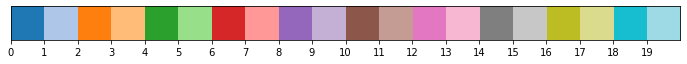

In [70]:
##Use this to choose colours for the horizontal barplots
from matplotlib import colors

def view_colormap(cmap):
    """Plot a colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    
    fig, ax = plt.subplots(1, figsize=(12, 3),
                           subplot_kw=dict(xticks=range(len(colors)), yticks=[]))
    ax.imshow([colors], extent=[0, len(colors), 0, 1])

    
view_colormap('tab20')

In [71]:
def makeCmap(name, color_nums):
    cmap = plt.get_cmap(name)
    cmap2 = colors.ListedColormap([cmap.colors[i] for i in color_nums])
    #bounds=[i for i in range(len(color_nums))]
    #norm = colors.BoundaryNorm(bounds, cmap2.N)
    
    return cmap2#, norm

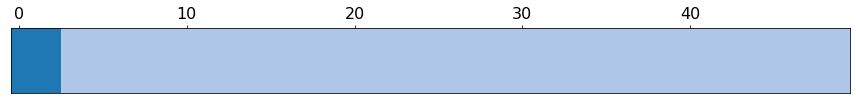

In [72]:
cmap = makeCmap('tab20', [0, 1])


arr = np.zeros([50,1])
arr[0:both+pos+neg] = 0
arr[both+pos+neg:] = 1

#cmap = plt.get_cmap('tab20')
#cmap = plt.cm.get_cmap('Blues', 2)
fig, ax = plt.subplots(1)
fig.set_figheight(1.5)
fig.set_figwidth(12)
ax.xaxis.tick_top()
ax.set_yticks([])

ax.tick_params(axis="x", labelsize=16)
ax.imshow(arr.T, cmap=cmap, aspect='auto')
plt.tight_layout()
#fig.savefig('total_assays.png')

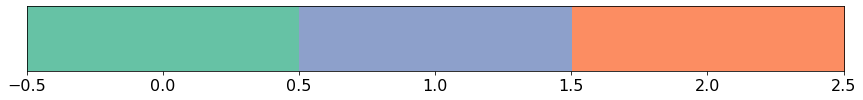

In [73]:
#Use this when you have active, inactive, and ambiguous evidence
#cmap = makeCmap('Set2', [1,2,0])

#Use this for the demo, where we only have active evidence (the 
#order gets messed up when there's only one type of result)
cmap = makeCmap('Set2', [0,2,1])


arr = np.zeros([pos+both+neg,1])
arr[0:neg] = 0
arr[neg:neg+both] = 1
arr[neg+both:] = 2


#cmap = plt.cm.get_cmap('Blues', 2)
fig, ax = plt.subplots(1)
fig.set_figheight(1.5)
fig.set_figwidth(12)
#ax.xaxis.tick_top()
ax.set_yticks([])
ax.tick_params(axis="x", labelsize=16)
plt.tight_layout()
ax.imshow(arr.T, cmap=cmap, aspect='auto')

#fig.savefig('assay_results.png')

In [76]:
targs = list()

for count, pair in enumerate(arr_sorted[:10000]):
    predicted_target = targets['pref_name'].iloc[pair[1]]
    targs.append(predicted_target)
    
pdf = pd.DataFrame(targs)

a= pdf.iloc[positive_targs][0].value_counts()

In [83]:
#Print out percentages of ambiguous evidence, negative evidence, and positive evidence
tot = both+pos+neg
print('Num negative assays:', neg)
print(neg/tot*100)

print('Num with ambiguous assay evidence:', both)
print(both/tot*100)

print('Num with positive assay evidence:', pos)
print(pos/tot*(100))


Num negative assays: 1
33.33333333333333
Num with ambiguous assay evidence: 1
33.33333333333333
Num with positive assay evidence: 1
33.33333333333333
